In [7]:
import pandas as pd

df = pd.read_csv("../data/discord_6m_messages.csv")

df["event_time"] = pd.to_datetime(df["event_time"], utc=True, errors="coerce")

df = df.dropna(subset=["event_time"])

df["week"] = df["event_time"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_messages = (
    df.groupby("week")
    .size()
    .reset_index(name="message_count")
)

print(weekly_messages.head())


C:\Users\sasan\AppData\Local\Temp\ipykernel_15080\3992580509.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["event_time"].dt.to_period("W").apply(lambda r: r.start_time)


        week  message_count
0 2025-06-16            129
1 2025-06-23            234
2 2025-06-30            355
3 2025-07-07            612
4 2025-07-14            129


In [8]:
weekly_active_users = (
    df.groupby("week")["user_id"]
    .nunique()
    .reset_index(name="active_users")
)

print(weekly_active_users)


         week  active_users
0  2025-06-16            30
1  2025-06-23            39
2  2025-06-30            42
3  2025-07-07            44
4  2025-07-14            35
5  2025-07-21            46
6  2025-07-28            33
7  2025-08-04            40
8  2025-08-11            51
9  2025-08-18            31
10 2025-08-25            77
11 2025-09-01            45
12 2025-09-08            50
13 2025-09-15            53
14 2025-09-22            32
15 2025-09-29            28
16 2025-10-06            85
17 2025-10-13            37
18 2025-10-20            43
19 2025-10-27            44
20 2025-11-03            21
21 2025-11-10            28
22 2025-11-17            20
23 2025-11-24            21
24 2025-12-01            34
25 2025-12-08            24
26 2025-12-15             9


In [9]:
weekly_users = (
    df.groupby("week")["user_id"]
    .apply(set)
    .reset_index(name="users")
)

returning = []

for i in range(1, len(weekly_users)):
    prev_users = weekly_users.loc[i - 1, "users"]
    curr_users = weekly_users.loc[i, "users"]

    returning.append({
        "week": weekly_users.loc[i, "week"],
        "returning_users": len(prev_users & curr_users)
    })

weekly_returning_users = pd.DataFrame(returning)

print(weekly_returning_users)

         week  returning_users
0  2025-06-23                9
1  2025-06-30               17
2  2025-07-07               20
3  2025-07-14               19
4  2025-07-21               15
5  2025-07-28               18
6  2025-08-04               17
7  2025-08-11               15
8  2025-08-18               15
9  2025-08-25               16
10 2025-09-01               21
11 2025-09-08               16
12 2025-09-15               20
13 2025-09-22               19
14 2025-09-29               10
15 2025-10-06               12
16 2025-10-13               14
17 2025-10-20               14
18 2025-10-27               17
19 2025-11-03                9
20 2025-11-10                7
21 2025-11-17                9
22 2025-11-24                9
23 2025-12-01                8
24 2025-12-08                9
25 2025-12-15                2


In [10]:
weekly_active_users_shifted = weekly_active_users.copy()
weekly_active_users_shifted["prev_active_users"] = weekly_active_users_shifted["active_users"].shift(1)

weekly_ratio = weekly_returning_users.merge(
    weekly_active_users_shifted[["week", "prev_active_users"]],
    on="week",
    how="left"
)

weekly_ratio["returning_user_ratio"] = (
    weekly_ratio["returning_users"] / weekly_ratio["prev_active_users"]
)

print(weekly_ratio)

         week  returning_users  prev_active_users  returning_user_ratio
0  2025-06-23                9               30.0              0.300000
1  2025-06-30               17               39.0              0.435897
2  2025-07-07               20               42.0              0.476190
3  2025-07-14               19               44.0              0.431818
4  2025-07-21               15               35.0              0.428571
5  2025-07-28               18               46.0              0.391304
6  2025-08-04               17               33.0              0.515152
7  2025-08-11               15               40.0              0.375000
8  2025-08-18               15               51.0              0.294118
9  2025-08-25               16               31.0              0.516129
10 2025-09-01               21               77.0              0.272727
11 2025-09-08               16               45.0              0.355556
12 2025-09-15               20               50.0              0

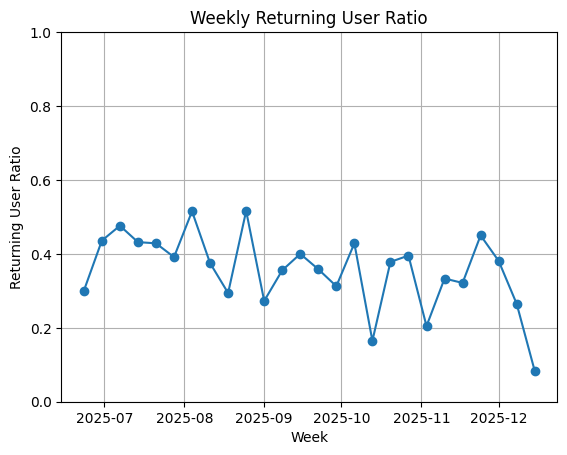

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    weekly_ratio["week"],
    weekly_ratio["returning_user_ratio"],
    marker="o"
)

plt.xlabel("Week")
plt.ylabel("Returning User Ratio")
plt.title("Weekly Returning User Ratio")

plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [12]:
def classify_health(ratio):
    if ratio >= 0.40:
        return "Healthy"
    elif ratio >= 0.25:
        return "Warning"
    else:
        return "Critical"

weekly_ratio["health_status"] = weekly_ratio["returning_user_ratio"].apply(classify_health)

print(weekly_ratio[["week", "returning_user_ratio", "health_status"]])


         week  returning_user_ratio health_status
0  2025-06-23              0.300000       Warning
1  2025-06-30              0.435897       Healthy
2  2025-07-07              0.476190       Healthy
3  2025-07-14              0.431818       Healthy
4  2025-07-21              0.428571       Healthy
5  2025-07-28              0.391304       Warning
6  2025-08-04              0.515152       Healthy
7  2025-08-11              0.375000       Warning
8  2025-08-18              0.294118       Warning
9  2025-08-25              0.516129       Healthy
10 2025-09-01              0.272727       Warning
11 2025-09-08              0.355556       Warning
12 2025-09-15              0.400000       Healthy
13 2025-09-22              0.358491       Warning
14 2025-09-29              0.312500       Warning
15 2025-10-06              0.428571       Healthy
16 2025-10-13              0.164706      Critical
17 2025-10-20              0.378378       Warning
18 2025-10-27              0.395349       Warning
